<a href="https://colab.research.google.com/github/Aditya-raj22/telco-churn-analysis/blob/main/churn_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook analyzes customer churn data from a telecommunications company to understand factors contributing to customer attrition and develop interpretable predictive models.


Objective: Build and compare different statistical models to predict customer churn and provide actionable insights for retention strategies.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, classification_report, roc_auc_score
from pygam import LogisticGAM, s
import warnings; warnings.filterwarnings('ignore')

# Load data
from google.colab import files
uploaded = files.upload()  # Click "Choose Files" and select your downloaded CSV
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# If file already uploaded to Colab files
# df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Fix TotalCharges and Churn
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Encode ALL categorical variables properly
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                   'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in categorical_cols:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# One-hot encode remaining multi-category variables
multi_cat_cols = ['Contract', 'PaymentMethod', 'InternetService']
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

# Prepare features - ensure all are numeric
feature_cols = [col for col in df.columns if col not in ['customerID', 'Churn']]
X, y = df[feature_cols], df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dataset shape: (7043, 25)
Churn rate: 0.265


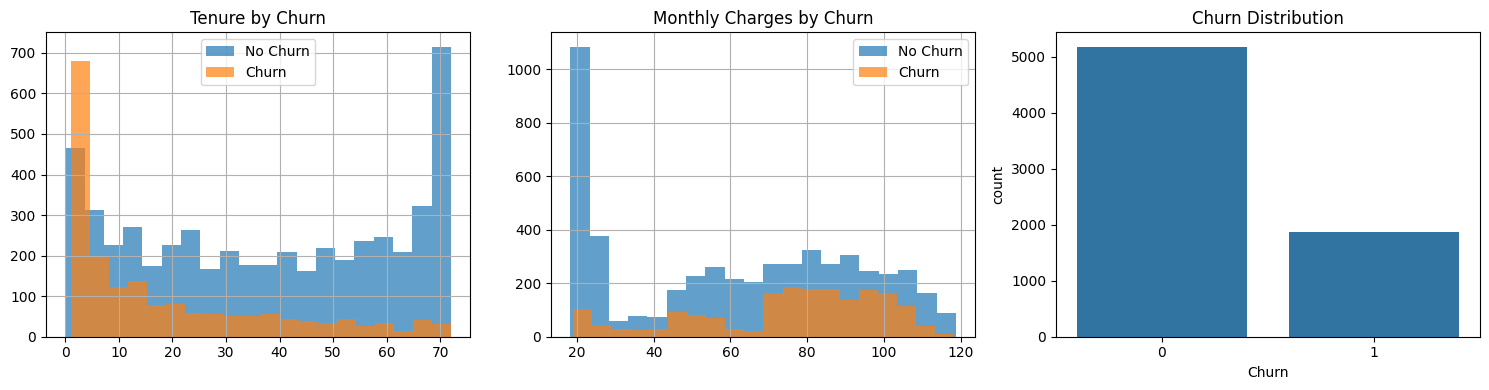

In [7]:
# Basic EDA
print(f"Dataset shape: {df.shape}")
print(f"Churn rate: {y.mean():.3f}")

# Visualize key relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
df.groupby('Churn')['tenure'].hist(alpha=0.7, ax=axes[0], bins=20)
axes[0].set_title('Tenure by Churn'); axes[0].legend(['No Churn', 'Churn'])

df.groupby('Churn')['MonthlyCharges'].hist(alpha=0.7, ax=axes[1], bins=20)
axes[1].set_title('Monthly Charges by Churn'); axes[1].legend(['No Churn', 'Churn'])

sns.countplot(data=df, x='Churn', ax=axes[2])
axes[2].set_title('Churn Distribution')
plt.tight_layout(); plt.show()

We can see that the dataset contains 7,043 customers with 25 features each. The churn rate is 0.265. This means that 26.5% of customers left the company - it's a significant problem indeed!

From an initial analysis, we can see that new customers (within their first year) are at highest risk to churn. Further, higher prices correlate with increased churn risk.



In [14]:
# Scale features and fit linear model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_model = LinearRegression().fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate model
print("=== LINEAR REGRESSION ===")
print(f"R²: {r2_score(y_test, y_pred_linear):.3f}")
print(f"Accuracy: {accuracy_score(y_test, (y_pred_linear > 0.5)):.3f}")

# Feature importance
importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': linear_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(5)
print("\nTop 5 Features:")
print(importance)

=== LINEAR REGRESSION ===
R²: 0.311
Accuracy: 0.823

Top 5 Features:
                        Feature  Coefficient
21  InternetService_Fiber optic     0.139815
22           InternetService_No    -0.136810
14               MonthlyCharges    -0.134721
15                 TotalCharges    -0.094277
12              StreamingMovies     0.047510


The low R^2 value of 0.311 indicates that a linear regression only has low to moderate predicitve power in this dataset. Suprisingly, it has a high accuracy of 82.3%. Ultimately, it is the wrong statistical tool for this dataset.

My most important takeaways regarding churn prediction are:
1. Fiber customers 14% more likely to churn (possibly due to higher expectations)
2. No internet customers are 13.7% less likely to churn (likely fewer options at that package)
3. Higher monthly charges mean a customer is 13.5% less likely to churn (Perhpas the premium packages offer much stickier value/ services)
4. Higher lifetime value customers are 9.4% less likely to churn (This makes sense - we've built trust with them)
5. Movie streaming customers are 4.8 % more likely to churn (They're possibly more service-conscious, comparison shoppers)



In [15]:
# Fit logistic regression
logistic_model = LogisticRegression(random_state=42).fit(X_train_scaled, y_train)
y_pred_logistic = logistic_model.predict(X_test_scaled)
y_pred_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("=== LOGISTIC REGRESSION ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logistic):.3f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Feature importance (odds ratios)
odds_ratios = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': logistic_model.coef_[0],
    'Odds_Ratio': np.exp(logistic_model.coef_[0])
}).sort_values('Coefficient', key=abs, ascending=False).head(5)
print("\nTop 5 Features (Odds Ratios):")
print(odds_ratios)

=== LOGISTIC REGRESSION ===
Accuracy: 0.820
AUC: 0.862

Top 5 Features (Odds Ratios):
                        Feature  Coefficient  Odds_Ratio
4                        tenure    -1.353771    0.258264
15                 TotalCharges     0.653484    1.922225
17            Contract_Two year    -0.612125    0.542197
21  InternetService_Fiber optic     0.570586    1.769304
14               MonthlyCharges    -0.506216    0.602772


The accuracy of the logistic model is 82% (slightly lower than the linear model at 82.3%) yet the AUC is 0.862 which implies it has a much higher predicitve power and is statistically much more relevant to distinguish churners from non-churners.

The Odds ratio tells us the directional impact of the top 5 features:
1. For each additional unit of tenure, churn odds decrease by 74%. This implies that longer customers are MUCH less likely to leave so early retention is critical.
2. Higher total charges increase churn odds by 92%, which contradicts my expectation that usage breeds loyalty. It's possuble that customers with high bills feel they're overpaying, might be worth a survey/ focus group.
3. Two-year contracts reduce churn odds by 46%, so long contracts work for retention and we should push enterprises towards that.
4. Fiber customers are 77% more likely to churn. This backs our linear modeling insight that premium service customers are pickier and we need a better fiber customer experience.
5. Higher monthly charges reduce churn odds by 40%. So premium customers get better perceived service/value.





In [17]:
# Check correlation between these variables
print("Correlation check:")
print(f"MonthlyCharges vs TotalCharges: {df['MonthlyCharges'].corr(df['TotalCharges']):.3f}")
print(f"tenure vs TotalCharges: {df['tenure'].corr(df['TotalCharges']):.3f}")
print(f"MonthlyCharges vs tenure: {df['MonthlyCharges'].corr(df['tenure']):.3f}")

Correlation check:
MonthlyCharges vs TotalCharges: 0.651
tenure vs TotalCharges: 0.826
MonthlyCharges vs tenure: 0.248


As I suspected from the contradictory finding that higher total charges increase chruen odds, we're running into the multicollinearity Problem! Our variables are correlated - especially tenure and total charge. GAMs should help us with this as they handle correlated variables better, show non-linear relationships, and reveal if there are threshold effects we're missing.

=== GAM ===
Accuracy: 0.803


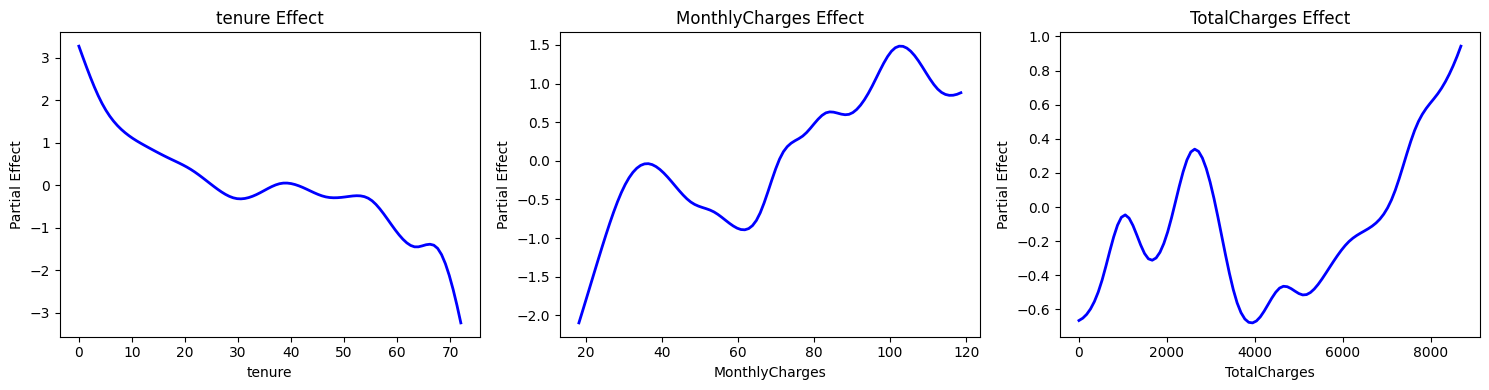

In [18]:
# Prepare numerical features for GAM
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_gam = df[num_features].values
X_gam_train, X_gam_test, y_gam_train, y_gam_test = train_test_split(X_gam, y, test_size=0.2, random_state=42)

# Fit GAM
gam_model = LogisticGAM(s(0) + s(1) + s(2)).fit(X_gam_train, y_gam_train)
y_pred_gam = gam_model.predict(X_gam_test)

print("=== GAM ===")
print(f"Accuracy: {accuracy_score(y_gam_test, y_pred_gam):.3f}")

# Plot partial dependence (simplified)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, feature in enumerate(num_features):
    XX = gam_model.generate_X_grid(term=i)
    pdep, confi = gam_model.partial_dependence(term=i, X=XX, width=0.95)

    axes[i].plot(XX[:, i], pdep, 'b-', linewidth=2)
    # Fix confidence interval plotting
    if len(confi) == 2 and len(confi[0]) == len(XX[:, i]):
        axes[i].fill_between(XX[:, i], confi[0], confi[1], alpha=0.3)
    axes[i].set_title(f'{feature} Effect')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Partial Effect')

plt.tight_layout(); plt.show()

The GAM's accuracy is 80.3% - slightly lower, but honestly I'm fine with that since we're catching non-linear patterns. What we see from the graphs are:
1. 0-10 months is when churn risk is ridiculosuly high, and then that risk drops quickly from months 10-30. There's a plateau of semi-loyal customers from 30-55 months, before churn risk drops steeply to create super loyal customers.
2. Budget customers are actually more loyal than premium customers. The perceived value of the 20$ and 60$ monthly packages seem like sweet spots.
3. Low and medium-lifetime spenders are quite loyal, but the low-medium lifetime spenders feel unhappy with their offerings, and the high lifetime spenders get sticker shock.

In [19]:
results = pd.DataFrame({
    'Model': ['Linear', 'Logistic', 'GAM'],
    'Accuracy': [
        accuracy_score(y_test, (y_pred_linear > 0.5)),
        accuracy_score(y_test, y_pred_logistic),
        accuracy_score(y_gam_test, y_pred_gam)
    ],
    'Interpretability': ['High', 'High', 'Medium'],
    'Non-linear': ['No', 'No', 'Yes']
})
print(results)

      Model  Accuracy Interpretability Non-linear
0    Linear  0.822569             High         No
1  Logistic  0.820440             High         No
2       GAM  0.803407           Medium        Yes


As we can see, the GAM model, while achieving slightly lower accuracy (80.3%), provides the most valuable business insights by capturing non-linear customer behavior patterns that linear models miss. The partial dependence plots reveal critical threshold effects: customers face highest churn risk in their first 10 months, pricing sweet spots exist around USD 20 and 60 monthly charges, and sticker shock occurs when lifetime spending exceeds USD 6,000. This explains the contradictory coefficients observed in linear regression, where multicollinearity between tenure and total charges creates misleading interpretations.

For the business, I'd recommend a hybrid approach: deploy the logistic regression model for daily customer risk scoring due to its high interpretability and robust performance, while using GAM insights to design targeted retention strategies. The trade-off between slightly lower accuracy but deeper understanding makes GAM much more useful for strategic decision-making as compaed to linear models.

Next steps for the business from a strategy perspective would be:
1. Offer enhanced discounts and customer service for customers within their first year to get over that 0-10 month churn cliff.
2. Migrate customers to USD 40-60 pricing tier with targeted offers to get to that sweet spot with lower churn risk
3. Enhance premium service value or bundle discounts to keep our high roller customers.
4. Implement loyalty rewards and VIP perks when customers hit USD 3000+ lifetime spend.
5. Revitalize the fiber offerings